# Unsupervised State-Inference
In reinforcement learning, it's often useful to assume that we can describe a problem in a discrete and finite set of states. For example, we might have an known number of independent bandits, or a grid-world with defined locations of objects. One reason this representation is useful is that it can dramtically simplify the problem of planning: given a known set of states $S$, a transition function $T(s,a,s') = p(s'|s,a)$ that defines the conditional probability of arriving in state $s'$ having taken action $a$ in state $s'$, and reward function $R(s, a, s')$ that defines the values over our state-action space, there are known polynomial time planning algorithms. 

In naturalistic enviornments, however, it can be difficult to translate raw perceptual stimuli into discrete states. Typically, states are an assumption of an enviornment and we often lack a principaled way to discover them from observation alone.  

Here, the goal is to discover states using an unsupervised learning algorithm.  We'll assume states are discrete, independent latent variables and use variational inference to learn conditional probability distribution over states. More formally, given a real-valued observation vector $x\in R^d$, we want to learn a paramterized function $f_\theta(x)$ that defines a probability distribution over states $s$. We'll assume that we don't have access to the states, but only have the observation tuples $(x, x')$ that define transitions an agent makes in an enviornment. We will use a discrete variaitional autoencoder (VAE) for our unsupervised algorithm.




In [1]:
# ### Comment out for local run
# !pip install git+https://github.com/nicktfranklin/value_iteration_network.git

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.utils.data as data
from sklearn.metrics import pairwise_distances
from torch.utils.data import Dataset
from sklearn import svm

import utils.state_inference as utils
from environments.state_inference import ObservationModel, TransitionEstimator
from environments.state_inference import RewardEstimator
from environments.state_inference import make_cardinal_transition_function, value_iteration
from models.state_inference import QUIET, DEVICE, train_epochs, Encoder, Decoder, mDVAE


In [4]:
import sys
print(f"python {sys.version}")
print(f"torch {torch.__version__}")
print(f"device = {DEVICE}")

python 3.9.16 (main, Mar  8 2023, 04:29:24) 
[Clang 14.0.6 ]
torch 2.0.0
device = mps


## Toy World
First, it's useful to construct a toy world and the stimuli we'll need for the model. I'm making the assumption that the underlying MDP is a $n\times n$ grid-world that's embedded in much higher dimensional observational space. To do so, I'll construct a much larger grid with dimensions $m\times m$, where $m > n$, and evenly space the states in the grid. I then add a couple of sources of noise and convole the observations with a Gaussian kernel to generate the observations.  This increases the dimensionality substantially (going from $n^2$ to $m^2$) and adds significant overlap between the observations.

We can think of these observations as a toy model for soemthing like a robot's estimate of it's position, or a perhaps as a model of hippocampal grid cells.  Importantly, this doesn't have to be exclusively a spatial model -- none of the subsequent modeling uses visual inductive biases and I'm hopeful this is more general toy model.

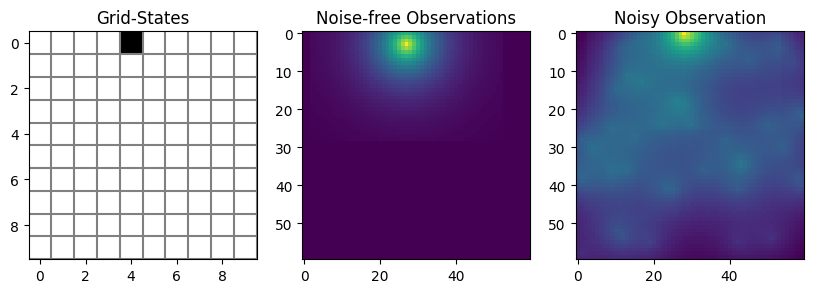

In [5]:
# Discritized states: a 10x10 grid of states, which we embed by spacing 
# evenly in a nXn space
HEIGHT, WIDTH = 10, 10
MAP_HEIGHT = 60


gw_kwargs = dict(
    rbf_kernel_size = 51, # must be odd
    rbf_kernel_scale = .15,
    location_noise_scale = 4.0
)

        
observation_model = ObservationModel(HEIGHT, WIDTH, MAP_HEIGHT, **gw_kwargs)
    

# show an example location
s = 4
observation_model.display_state(s)


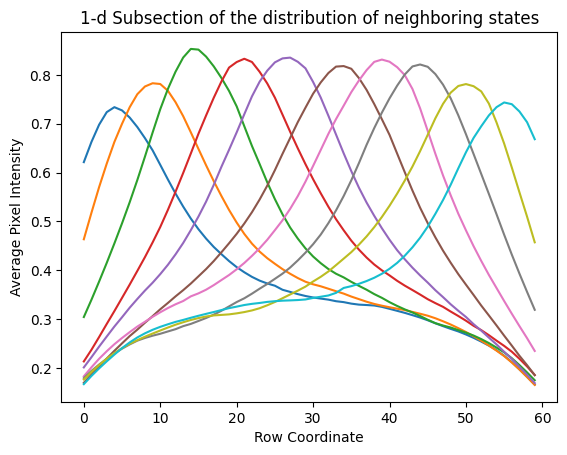

In [6]:
## show the 1-d overlap of neighboring states
x, _ = observation_model.get_obs_coords(26)

[plt.plot(np.mean([
    observation_model.embed_state_corrupted(s)[x, :] for _ in range(100)
], axis=0))
for s in range(20, 30)]

plt.xlabel('Row Coordinate')
plt.ylabel('Average Pixel Intensity')
plt.title('1-d Subsection of the distribution of neighboring states')
plt.show()


Notably, there is a overlap in our observation space. We can control this overlap parametrically by changing the length scale of our convolution kernel (this is akin to a wider belief distribution)

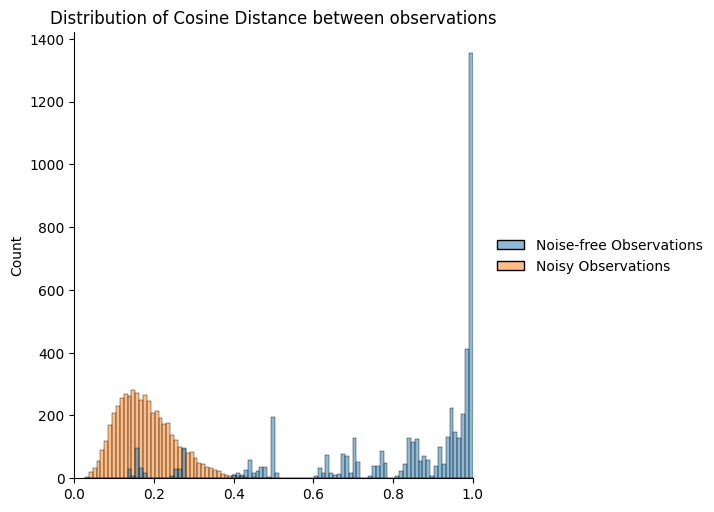

In [7]:
def pairwise_embedding_distances(observation_model, corrupt=False):
    def embed(s):
        if corrupt:
            return observation_model.embed_state_corrupted(s).reshape(-1) 
        return observation_model.embed_state(s).reshape(-1) 
    
    sample_embeddings = {
        s: embed(s)
        for s in observation_model.states.keys()
    }

    distances = pairwise_distances(
        np.array(list(sample_embeddings.values())), metric="cosine"
    )

    mask = np.tril(np.ones_like(distances, dtype=bool), k=-1)
    return distances.reshape(-1)[mask.reshape(-1)]

  

sns.displot(
   {
    'Noise-free Observations': pairwise_embedding_distances(
       observation_model, corrupt=False
       ),
    'Noisy Observations': pairwise_embedding_distances(
       observation_model, corrupt=True
       ),
   },
   bins=100
)

plt.title('Distribution of Cosine Distance between observations')
plt.xlim([0,1])
plt.show()

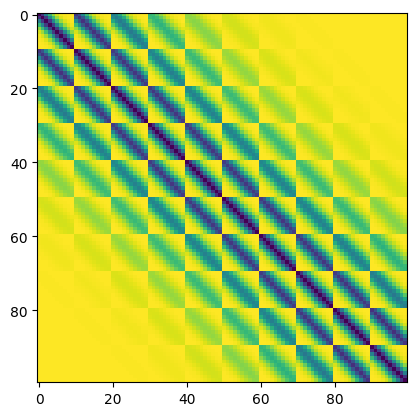

In [8]:
sample_embeddings = {}
for s in observation_model.states.keys():
    sample_embeddings[s] = observation_model.embed_state(s).reshape(-1)

noise_free_embedding_distances = pairwise_distances(
    np.array(list(sample_embeddings.values())), metric="cosine"
)
plt.imshow(
noise_free_embedding_distances)

### Random Walk 
Define a random walk over the grid-world and plot a sample trajectory

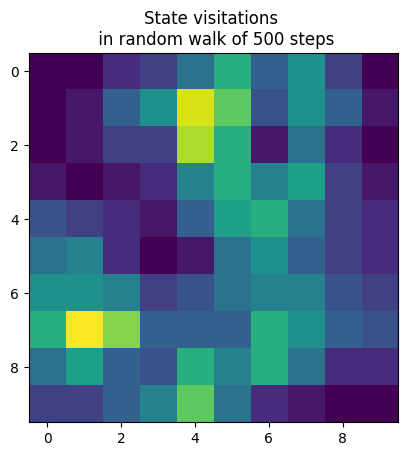

In [9]:
# Define a random walk between coordinate neighbors. 
# This is will be used to during training


from environments.state_inference import TransitionModel

walk_length = 500

grid_transitions = TransitionModel(HEIGHT, WIDTH)
state_counts, walk = grid_transitions.generate_random_walk(walk_length)

plt.imshow(state_counts.reshape(HEIGHT, WIDTH))
plt.title(f'State visitations \n in random walk of {walk_length} steps')
plt.show()

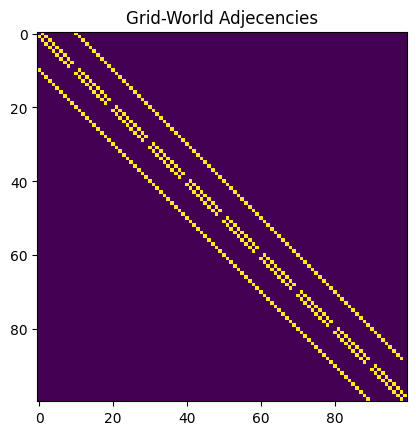

In [10]:
plt.imshow(grid_transitions.transitions > 0)
plt.title('Grid-World Adjecencies')
plt.show()

## Discrete State-VAE
The core idea is to use a discrete Variational Autoencoder, where states are represented as one-hot vector embeddings. The VAE is an encoder/decoder model, where the encoder learns a parameterized probability distribution over embeddings and the decoder reconstructs the original input vector from the vector embedding. 

The model has three key components:
* An encoder model: $f_\theta(x) = \omega$
* A Gumbel-Sofmax probability distribution over states $p_\omega(z) \propto exp(\omega + \epsilon)$, where $ \epsilon$ is an external source of noise drawn from the Gumbel distribution.
* A decoder model: $d_\theta(z) = x$

The model is trained with stochastic variational gradient descent: an input is passed through the decoder, a state is sampled from the Gumbel-softmax distribution, and the input is reconstructed by the decoder. This forward pass is used to calculate the ELBO loss function:
$$ELBO(x) = \log q(x|z) - KL(q(z|x)||p(z))$$
where $\log q(x|z)$ is the reconstruction loss of the network and $KL(q(z|x)||p(z))$ is the KL diveregence of the learned embedding distribution and a prior over states. Under gentle assumptions, $-\log q(x|z)$ is the mean squared error of the reconstructed output relative to the input and the $KL(q(z|x)||p(z))$ becomes the entropy of the embedding distribution.




### Model
This is the code for the VAE

### Training Functions
Helper functions to train the model

### Generate Dataset
Sample states from a Random walk on the grid-world and then generate noisy observations

In [11]:
### Simulation Parameters
N_TRAINING_EXAMPLES = 10000
BATCH_SIZE = 64

######

# for training, use a single random walk and noisy observations
train_states = grid_transitions.sample_states(N_TRAINING_EXAMPLES, 'walk')
train_observations = np.array([
    observation_model.embed_state_corrupted(s).reshape(-1)
    for s in train_states
])

_, d = train_observations.shape


# for test, use the uncorrupted dataset
test_observations = np.array([
    observation_model.embed_state(s).reshape(-1)
    for s in range(grid_transitions.n_states)
])


# Create the dataloaders from the dataset
train_loader = data.DataLoader(train_observations, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_observations, batch_size=BATCH_SIZE)

### Train the Model

In [12]:
# from models import mDVAE, MLP, MLP

### Model + Training Parameters
N_EPOCHS = 20 # should be 20
EMBEDDING_LAYERS = 5
EMBEDDING_DIM = len(observation_model.states) // 2
LR = 1e-4
beta = 2.0
tau = 1.0
gamma = 0.95
dropout = 0.01

# # create the model
vae_kwargs = dict(z_dim=EMBEDDING_DIM, z_layers=EMBEDDING_LAYERS,
                  beta=beta, tau=tau, gamma=gamma)
z_dim = EMBEDDING_DIM * EMBEDDING_LAYERS
encoder = Encoder(d, [d // 5, d // 10], z_dim, dropout=dropout)
decoder = Decoder(z_dim, [d // 10, d // 5], d, dropout=dropout)
vae_model = mDVAE(encoder, decoder, **vae_kwargs).to(DEVICE)
print(vae_model)

mDVAE(
  (encoder): Encoder(
    (net): Sequential(
      (0): Linear(in_features=3600, out_features=720, bias=True)
      (1): BatchNorm1d(720, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.01, inplace=False)
      (3): ReLU()
      (4): Linear(in_features=720, out_features=360, bias=True)
      (5): BatchNorm1d(360, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Dropout(p=0.01, inplace=False)
      (7): ReLU()
      (8): Linear(in_features=360, out_features=250, bias=True)
      (9): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (decoder): Decoder(
    (net): Sequential(
      (0): Linear(in_features=250, out_features=360, bias=True)
      (1): BatchNorm1d(360, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.01, inplace=False)
      (3): ReLU()
      (4): Linear(in_features=360, out_features=720, bias=True)
      (5): BatchNorm1d(7

In [13]:
# Train the the model
train_losses, test_losses = train_epochs(
    vae_model, train_loader, test_loader, dict(epochs=N_EPOCHS, lr=LR, clip_grad=True)
    )

Epoch 0, ELBO Loss (test) 4.2843
Epoch 1, ELBO Loss (test) 3.9823
Epoch 2, ELBO Loss (test) 3.0250
Epoch 3, ELBO Loss (test) 2.3237
Epoch 4, ELBO Loss (test) 2.2184
Epoch 5, ELBO Loss (test) 1.8590
Epoch 6, ELBO Loss (test) 1.6351
Epoch 7, ELBO Loss (test) 1.8737
Epoch 8, ELBO Loss (test) 2.1269
Epoch 9, ELBO Loss (test) 1.6873
Epoch 10, ELBO Loss (test) 1.8115
Epoch 11, ELBO Loss (test) 1.7596
Epoch 12, ELBO Loss (test) 1.8323
Epoch 13, ELBO Loss (test) 1.5524
Epoch 14, ELBO Loss (test) 1.4880
Epoch 15, ELBO Loss (test) 1.5186
Epoch 16, ELBO Loss (test) 1.5538
Epoch 17, ELBO Loss (test) 1.6144
Epoch 18, ELBO Loss (test) 1.2804
Epoch 19, ELBO Loss (test) 1.7962


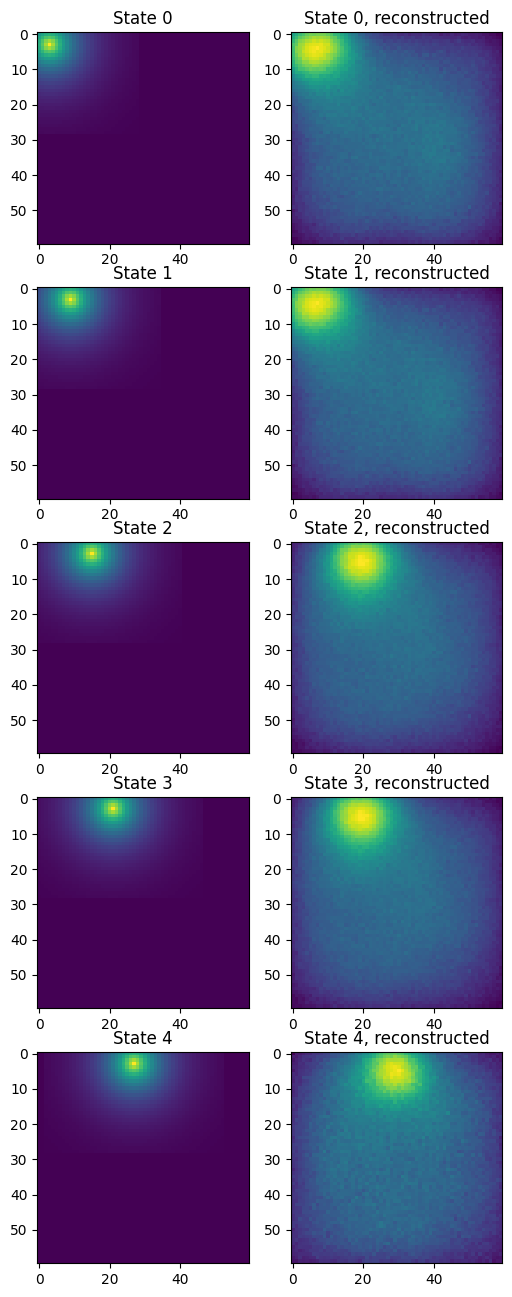

In [14]:
vae_model.eval()
s = np.random.randint(0, EMBEDDING_DIM)
ii = 0
fig, axes = plt.subplots(5, 2, figsize=(6, 16))
for s in range(5):
    X_hat = vae_model(torch.tensor(test_observations[s,:]).view(1, -1).to(DEVICE))

    axes[ii][0].imshow(torch.tensor(test_observations[s,:]).view(MAP_HEIGHT, MAP_HEIGHT))
    axes[ii][1].imshow(X_hat.view(MAP_HEIGHT, MAP_HEIGHT).detach().cpu().numpy())
    axes[ii][0].set_title(f'State {ii}')
    axes[ii][1].set_title(f'State {ii}, reconstructed')

    ii+=1



### Evaluate State-Inference


In [15]:
n = 10000

# generate a new set of observations for training
y_train = grid_transitions.sample_states(n, 'random')
# y_test = grid_transitions.sample_states(n, 'random')


# Use a trained classifier to determine states from latent representation
recon_model = utils.StateReconstruction(
    vae_model, observation_model, y_train
)


/Users/nicholasfranklin/miniconda3/envs/state-inf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
n = 100
y_test = grid_transitions.sample_states(n, 'random')
y_hat_log_prob = recon_model.predict_log_prob(y_test)
recon_model.score(y_test)

0.19909787488572128

Text(0.5, 1.0, 'Inferred log probability map over states')

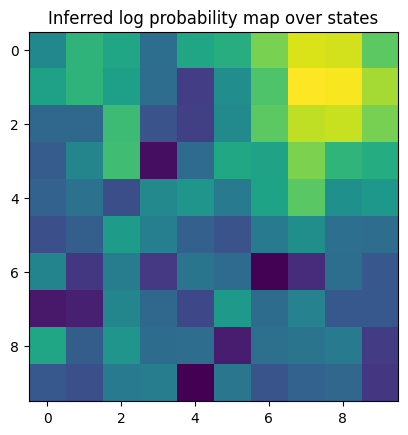

In [17]:
plt.imshow(y_hat_log_prob[10].reshape(HEIGHT, WIDTH))
plt.title('Inferred log probability map over states')

In [27]:
recon_model.entropy(y_hat_log_prob)

array([[0.62749739, 1.23451333, 1.52280827, 0.94187818, 0.75248096,
        1.48015795, 1.47261918, 2.93776886, 1.5037877 , 0.63785955,
        0.56660172, 1.46182084, 2.03267696, 1.09281852, 0.95419834,
        1.17366399, 1.28177806, 2.05567332, 1.39812938, 1.55920343,
        0.76877771, 0.87320962, 1.64581599, 1.29214675, 1.55399025,
        1.06524056, 1.68873075, 1.36200966, 1.79428835, 1.22675038,
        0.90871989, 0.84662126, 0.69272365, 1.51855981, 1.66655627,
        1.70320335, 1.33833101, 0.98724117, 1.59930924, 1.57649253,
        0.78852991, 0.89862754, 1.76204193, 0.77071188, 1.16705052,
        1.28937116, 0.49410761, 1.27170173, 0.92404358, 0.53624898,
        0.98493446, 1.35308724, 2.08497909, 2.21324557, 2.02921817,
        1.30241374, 1.68019259, 0.88965292, 1.22282489, 0.90710712,
        1.49583737, 1.66613738, 2.23413938, 1.87155918, 2.56668337,
        2.74125197, 1.98713031, 2.62684321, 2.04804248, 1.67783725,
        1.45767762, 2.09872825, 1.91970211, 2.80

# Value Iteration
Now that we have a state-inference model, we want to take the model to do a planning task.  The first step is to generate a new random walk, where rewards are observed (ideally a much shorter walk) and use these to estimate a transition and reward function.  We can then use value iteration, and re-projecte the value function into the original space for visualization.  

Ultimately, we'd like to use a task.  We could implment DYNA-Q on the state space, and then recreate figure 8.2 from Sutton and Barto (second edition, page 165 below) 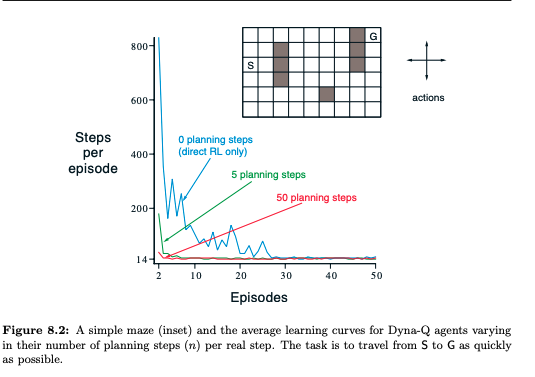

### Transition Function

In [19]:
transitions = make_cardinal_transition_function(HEIGHT, WIDTH)
transitions

{'up': array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'down': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 'left': array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.]]),
 'right': array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0

## Reward functions

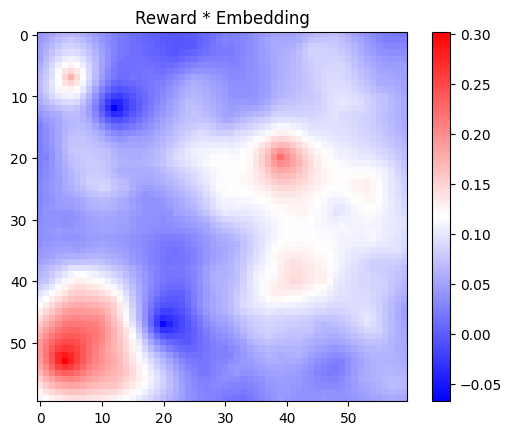

In [20]:
# Pick some interesting reward function
rewards = {
    72: -1,
    22: -1,
    45: +1,
    0: +1,
    90: +1,
}

# for Display purposes, we can show the reward function embedded in the original
# space.  This doesn't have a clean interpretation, but it shows us 
# roughly where pixels are associated with positive or negative reward

reward_map = np.mean(
    [observation_model(s) * r for s, r in rewards.items()], axis=0
).reshape(MAP_HEIGHT, -1)

plt.imshow(reward_map, cmap="bwr")
plt.title("Reward * Embedding")
plt.colorbar()
plt.show()


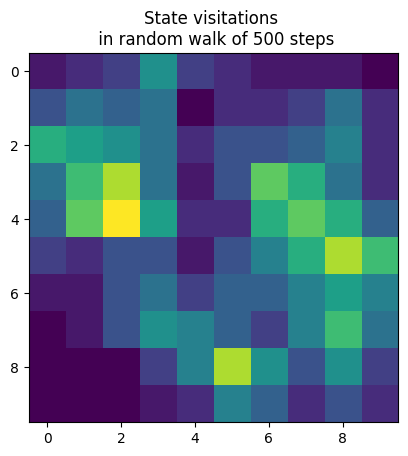

In [21]:
n = 500
state_counts, walk = grid_transitions.generate_random_walk(n)
plt.imshow(state_counts.reshape(HEIGHT, WIDTH))
plt.title(f'State visitations \n in random walk of {n} steps')
plt.show()

# observation_model()
walk_observations = torch.tensor(np.stack([
    observation_model(s).reshape(-1)
    # corrupt_embedding(states[s][0], states[s][1], map_height, kernel).reshape(-1)
    for s in walk
    ]))
walk_rewards = [rewards.get(s, 0) for s in walk]


## Value iteration

In [22]:
walk_states = vae_model.get_state(walk_observations.to(DEVICE)).detach().cpu().numpy()
walk_states = [tuple(s) for s in walk_states]

transition_model = TransitionEstimator()
transition_model.batch_update(walk_states)

reward_model = RewardEstimator()
reward_model.batch_update(walk_states, walk_rewards)

In [23]:
q, v = value_iteration(
    {'N': transition_model},
    reward_model,
    gamma=0.80,
    iterations=100
    )

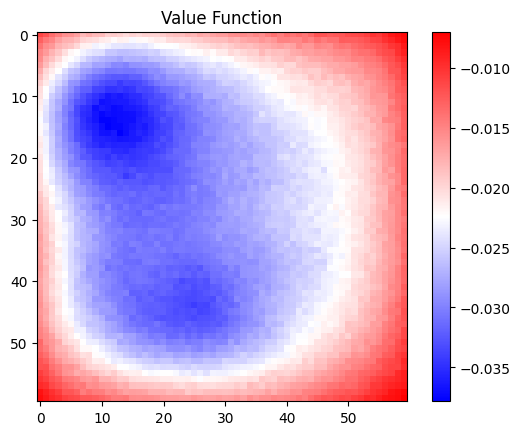

In [24]:
value_function = []
for (s, vs) in v.items():
  x = vae_model.decode_state(s)
  value_function.append(x * vs)

plt.imshow(
    np.array(value_function).squeeze().mean(axis=0).reshape(MAP_HEIGHT, -1),
    cmap='bwr'
)

# plt.imshow(reward_map, cmap="bwr")
plt.title("Value Function")
plt.colorbar()
plt.show()